In [1]:
import numpy as np
import pandas as pd
import csv
import nltk
import string
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
sno = nltk.stem.SnowballStemmer('english')

import os

path, dirs, files = next(os.walk("directory"))
file_count = len(files)

In [2]:
cols=['Average_rate_per_night','Bedrooms_count','City','Date_of_listing','Description','Latitude','Longitude','Title','Url']
df = pd.DataFrame([])
for i in range(file_count):
    filename = 'directory/doc_{}.tsv'.format(i+1)
    df = df.append(pd.read_csv(filename,sep='\t',header=None).T,ignore_index=True)
df.columns = cols

In [3]:
all_cities = pd.read_csv('uscitiesv1.4.csv')
texas = all_cities[all_cities.state_name=='Texas']

In [4]:
cities_cord = {}
for city in df.City.unique():
    if city in texas.city.values:
        cities_cord[city] = [texas[texas.city == city].lat.iloc[0],texas[texas.city == city].lng.iloc[0]]

In [5]:
df.dropna(inplace=True)
lat = df.Latitude.apply(pd.to_numeric,errors='coerce').values
long = df.Longitude.apply(pd.to_numeric,errors='coerce').values
X = [[l1,l2] for l1,l2 in zip(lat,long)]

In [6]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10).fit(X)

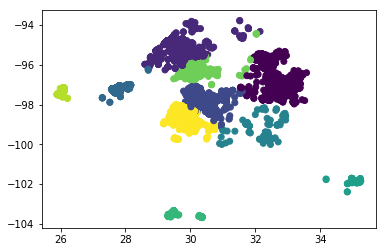

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(lat,long,c=kmeans.labels_)

In [8]:
import json

with open('regular_index.json', encoding='utf-8') as fp:
    indx = json.loads(fp.read())

with open('inverted_index.json', encoding='utf-8') as fp:
    inv_indx = json.loads(fp.read())

with open('words_transformation.json', encoding='utf-8') as fp:
    final_dict = json.loads(fp.read())

with open('words_inverse_transformation.json', encoding='utf-8') as fp:
    final_dict_inv = json.loads(fp.read())

* Example Query

In [9]:
query = 'a beautiful house with garden and beach'
qprice = 60  #query average_price
qrooms = 2  #query average # of rooms
qarea = 'San Antonio' #query area
if qarea in cities_cord.keys():
    la,lo = cities_cord[qarea]
else:
    from geopy.geocoders import Nominatim
    geolocator = Nominatim()
    la,lo = geolocator.geocode(qarea + " US")[-1]
qarea = kmeans.predict([[la,lo]])[0]  #clusterize area
q_values = [qprice/150,qrooms/10,qarea/10,la/30,lo/100]  #normalize values to a max value

**Query Process**

In [10]:
m_raw = query
#replace $ with dollar
m = re.sub('[$]','dollar',m_raw)
# replace new line symbols with whitespace
m = m.replace('\\r', ' ').replace('\\n', ' ')
#remove punctuations with 2 ways
#m = ''.join([c for c in m if c not in string.punctuation])
m = re.sub('[%s]' % re.escape(string.punctuation), ' ', m)
# seperate numbers from words
m = re.sub(r'(?<=[\d+])(?=[a-zA-Z_])', r' ', m)
# remove digits from messages
#m = ''.join(c for c in m if not c.isdigit())
m_new = nltk.tokenize.word_tokenize(m)
#remove stopwords
m_new = [word for word in m_new if word.lower() not in stopwords.words('english')]
#stemming of words
q = [sno.stem(word) for word in m_new]


In [11]:
q_new = [final_dict_inv[str(element)] for element in q if element in list(final_dict.values())]
documents = [inv_indx[str(term)] for term in q_new]
documents_final = set([y for x in documents for y in x])

In [12]:
df = pd.DataFrame([])
for i in documents_final:
    filename = 'directory/doc_{}.tsv'.format(i)
    #[7,4,2,8] taking only the elements that I was=nt to show to the user --> ['Title','Description','City','Url']
    df = df.append(pd.read_csv(filename,sep='\t',header=None).T,ignore_index=True)
df.columns = cols
df.index = list(range(1,len(documents_final)+1))
df.Bedrooms_count.replace('Studio',1,inplace=True)

In [13]:
price = df.Average_rate_per_night.str.split('$').str[-1].apply(pd.to_numeric).values/150
rooms = df.Bedrooms_count.apply(pd.to_numeric,errors='coerce').values/10
lat = df.Latitude.apply(pd.to_numeric,errors='coerce').values/30
long = df.Longitude.apply(pd.to_numeric,errors='coerce').values/100
lat = np.nan_to_num(lat)
long = np.nan_to_num(long)
X = [[l1,l2] for l1,l2 in zip(lat,long)]
cities = [kmeans.predict(X)][0]/10

In [14]:
matrix = np.array([price,rooms,cities,lat,long]).T
matrix

array([[ 0.99333333,  0.4       ,  0.1       ,  0.98343559, -0.98447688],
       [ 0.39333333,  0.1       ,  0.1       ,  0.99431174, -0.95081549],
       [ 0.4       ,  0.1       ,  0.1       ,  1.02124348, -0.96337846],
       ...,
       [ 0.66      ,  0.2       ,  0.1       ,  0.98176311, -0.98486756],
       [ 0.43333333,  0.2       ,  0.1       ,  0.98167142, -0.98505333],
       [ 0.5       ,  0.1       ,  0.1       ,  0.98085025, -0.98466833]])

In [15]:
from scipy.stats import chisquare
from heapq import heappush, heappop
score = []
for i in range(matrix.shape[0]):
    heappush(score,(chisquare(q_values,f_exp=matrix[i])[-1],list(documents_final)[i]))  

/home/jason/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:4567: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


In [16]:
#keeping only top-k documents
k = 100
score = sorted(score)[::-1]
for i in range(len(score)-k):
    heappop(score)

In [17]:
df = pd.DataFrame([])
score = sorted(score)[::-1]
docs = [k[1] for k in score]
for i in range(len(docs)):
    filename = 'directory/doc_{}.tsv'.format(docs[i])
    #[7,4,2,8] taking only the elements that I was=nt to show to the user --> ['Title','Description','City','Url']
    df = df.append(pd.read_csv(filename,sep='\t',header=None).T,ignore_index=True)
df.columns = cols
df['Ranking'] = [k[0] for k in score]
df.index = list(range(1,101))

In [18]:
df

,Average_rate_per_night,Bedrooms_count,City,Date_of_listing,Description,Latitude,Longitude,Title,Url,Ranking
1,$60,2,Richmond,August 2016,You'll love our Disney themed home. Breakfast ...,29.6943691211474,-95.8186072184166,Beautiful 2 rooms in Cinco Ranch one price,https://www.airbnb.com/rooms/14537988?location...,0.171247
2,$60,2,San Antonio,June 2016,"Two separate bedrooms bathroom, one low price!...",29.6444173636507,-98.46912876033069,"Beautiful Stone Oak Home--Sleeps 4-6, 1 Low Price",https://www.airbnb.com/rooms/13641385?location...,0.171199
3,$59,2,San Antonio,June 2014,Cute hideaway cottage only 1 mile from the Pea...,29.436481437867897,-98.4666852478495,"Tex-Mex Casita, close to Pearl!",https://www.airbnb.com/rooms/12220430?location...,0.171194
4,$60,2,College Station,August 2016,Beautiful new home located only minutes from T...,30.526488604435002,-96.2861311503616,Beautiful New Home Within Safe Quiet Neighborhood,https://www.airbnb.com/rooms/18284340?location...,0.171156
5,$60,2,Austin,May 2016,Charming two bedroom two bath apartment on the...,30.3246167896421,-97.6982328017979,Charming Two Bedroom Austin Apartment,https://www.airbnb.com/rooms/19357905?location...,0.171154
6,$60,2,Austin,March 2012,"A beautiful, modern home, surrounded by a beau...",30.411537948063803,-97.7563565117741,Stay at an architect's gorgeous home and garden!,https://www.airbnb.com/rooms/18998883?location...,0.171142
7,$60,2,Austin,March 2012,"A beautiful, modern home, surrounded by a beau...",30.411537948063803,-97.7563565117741,Stay at an architect's gorgeous home and garden!,https://www.airbnb.com/rooms/18998883?location...,0.171142
8,$62,2,Austin,June 2016,Welcome to our Hyde Park Hide-away! We're happ...,30.3068921600555,-97.72213786491301,Hyde Park Hide-away,https://www.airbnb.com/rooms/19177241?location...,0.171128
9,$58,2,Austin,April 2017,Awesome place to hang your head just north of ...,30.3279950998805,-97.7355445562328,Cozy 2br+2ba Austin home! 5 min to downtown!,https://www.airbnb.com/rooms/18378314?location...,0.171123
10,$58,2,Austin,April 2017,Awesome place to hang your head just north of ...,30.3279950998805,-97.7355445562328,Cozy 2br+2ba Austin home! 5 min to downtown!,https://www.airbnb.com/rooms/18378314?location...,0.171123
